In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def get_cuda_autotune_config():
    configs = []
    for num_warps in [4]:
        for num_stages in [2,3,4]:
            configs.append(
                triton.Config({"GROUP_SIZE_M" : 8, "BLOCK_SIZE_M" : 64, "BLOCK_SIZE_N" : 128, "BLOCK_SIZE_K" : 64}, num_stages=num_stages, num_warps=num_warps),
            )
            for GROUP_SIZE_M in [1]:
                for BLOCK_SIZE_M in [16]:
                    for BLOCK_SIZE_N in [16, 32, 64]:
                        for BLOCK_SIZE_K in [256]: #[64, 128, 256]:
                            configs.append(
                                triton.Config(
                                    {
                                        "GROUP_SIZE_M" : GROUP_SIZE_M,
                                        "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                        "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                        "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                    }, 
                                    num_warps=num_warps,
                                    num_stages=num_stages, 
                                ),
                            )
    return configs
    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 1,
                                    "BLOCK_SIZE_M" : 16,
                                    "BLOCK_SIZE_N" : 64,
                                    "BLOCK_SIZE_K" : 256,
                                },
                                num_warps=4,
                                num_stages=3
                            )]

def _matmul_launch_metadata(grid, kernel, args):
    ret = {}
    M, N, K = args["M"], args["N"], args["K"]
    kernel_name = kernel.name
    ret["name"] = f"{kernel_name} [M={M}, N={N}, K={K}]"
    ret["flops"] = 2.0 * M * N * K
    return ret

In [3]:
@triton.jit()
def swizzle_tile(pid,
                m, n,
                block_m: tl.constexpr, block_n: tl.constexpr, group_m: tl.constexpr):
    
    grid_m = tl.cdiv(m, block_m)
    grid_n = tl.cdiv(n, block_n)

    width = group_m * grid_n
    group_id = pid // width
    group_size = tl.minimum(grid_m - group_id * group_m, group_m)

    pid_m = group_id * group_m + (pid % group_size)
    pid_n = (pid % width) // group_size

    return pid_m, pid_n


@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def test_trellis_kernel(
        a_ptr, stride_am, stride_ak,
        b_ptr, stride_bk, stride_bn,
        c_ptr, stride_cm, stride_cn,
        # Matrix dimensions
        M, N, K,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    pid_m, pid_n = swizzle_tile(
        pid, M, N, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M
    )

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)


    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn_even = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N // 2)
    offs_bn_odd = pid_n * BLOCK_SIZE_N + tl.arange(BLOCK_SIZE_N // 2, BLOCK_SIZE_N)

    b_ptrs_even = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn_even[None, :] * stride_bn)
    b_ptrs_odd = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn_odd[None, :] * stride_bn)

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    mask_8bit = 0xFF
    shifter_8bit = tl.arange(0, 4) * 8
    shifter_4bit = tl.arange(0, 4) * 4

    gather_idx = tl.arange(1, 9)
    gather_idx = tl.where(gather_idx < 8, gather_idx, 0)

    a_mask = (offs_am[:, None] < M) & (offs_ak[None, :] < K)
    a = tl.load(a_ptrs, mask=a_mask, other=0.0)
    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_ak[None, :] + next_k_offset < K)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0)
        else:
            a_next = tl.zeros_like(a)
        
        k_compressed = k_idx * (BLOCK_SIZE_K // 16)
        b_mask_even = (offs_bk[:, None] + k_compressed < tl.cdiv(K, 16)) & (offs_bn_even[None, :] < N)
        b_mask_odd = (offs_bk[:, None] + k_compressed < tl.cdiv(K, 16)) & (offs_bn_odd[None, :] < N)

        b_packed_even = tl.load(b_ptrs_even, mask=b_mask_even, other=0)
        b_packed_odd = tl.load(b_ptrs_odd, mask=b_mask_odd, other=0)


        b_packed_even_next = tl.gather(
            src = b_packed_even.reshape(b_packed_even.shape[0], b_packed_even.shape[1] // 8, 8),
            index = gather_idx[None, None, :].broadcast_to(b_packed_even.shape[0], b_packed_even.shape[1] // 8, 8),
            axis=2
        ).reshape(b_packed_even.shape)
        b_packed_even_roll = ((b_packed_even >> 8) & 0xFFFFFF) | ((b_packed_even_next & 0xFF) << 24)


        bytes_even = (b_packed_even[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        bytes_even_rolled = (b_packed_even_roll[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        bytes_odd = (b_packed_odd[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        
        codes_even = bytes_even << 8 | bytes_odd
        codes_odd = bytes_odd << 8 | bytes_even_rolled
        codes = tl.join(codes_even, codes_odd)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)
        codes = codes.reshape(BLOCK_SIZE_K, BLOCK_SIZE_N // 4)

        vals = (codes[:, None, :] >> shifter_4bit[None, :, None]) & 0xF
        vals = vals.to(tl.int8) - 0x8

        b = vals.reshape(BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        # Advance the ptrs to the next K block.
        a = a_next
        b_ptrs_even += (BLOCK_SIZE_K // 16) * stride_bk
        b_ptrs_odd += (BLOCK_SIZE_K // 16) * stride_bk


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def test_trellis_triton(a, b_compressed):
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"

    M, K = a.shape
    N = b_compressed.shape[1]
    
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )

    test_trellis_kernel[grid](
        a, a.stride(0), a.stride(1),
        b_compressed, b_compressed.stride(0), b_compressed.stride(1),
        c, c.stride(0), c.stride(1),
        M, N, K
    )
    return c

In [4]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit(launch_metadata=_matmul_launch_metadata)
def test_trellis_kernel_(
        a_ptr, stride_am, stride_ak,
        b_ptr, stride_bk, stride_bn,
        c_ptr, stride_cm, stride_cn,
        # Matrix dimensions
        M, N, K,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)


    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)
    offs_bn_even = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N // 2)
    offs_bn_odd = pid_n * BLOCK_SIZE_N + tl.arange(BLOCK_SIZE_N // 2, BLOCK_SIZE_N)

    b_ptrs_even = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn_even[None, :] * stride_bn)
    b_ptrs_odd = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn_odd[None, :] * stride_bn)

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    mask_8bit = 0xFF
    next_mask = (tl.arange(0, 8)[None, :] == ((tl.arange(0, 8)[:, None] + 1) % 8))
    shifter_8bit = tl.arange(0, 4) * 8
    shifter_4bit = tl.arange(0, 4) * 4

    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        k_start = k_idx * BLOCK_SIZE_K
        a_mask = (offs_am[:, None] < M) & ((k_start + offs_ak[None, :]) < K)
        a = tl.load(a_ptrs, mask=a_mask, other=0.0)
        
        k_compressed = k_idx * (BLOCK_SIZE_K // 16)
        b_mask_even = (offs_bk[:, None] + k_compressed < tl.cdiv(K, 16)) & (offs_bn_even[None, :] < N)
        b_mask_odd = (offs_bk[:, None] + k_compressed < tl.cdiv(K, 16)) & (offs_bn_odd[None, :] < N)

        b_packed_even = tl.load(b_ptrs_even, mask=b_mask_even, other=0)
        b_packed_odd = tl.load(b_ptrs_odd, mask=b_mask_odd, other=0)

        b_packed_even_next = tl.sum(
            tl.where(
                next_mask[None, None, :, :], 
                b_packed_even.reshape(
                    b_packed_even.shape[0],
                    b_packed_even.shape[1] // 8,
                    8
                )[:, :, None, :],
                0
            ),
            axis=3
        ).reshape(b_packed_even.shape)
        b_packed_even_roll = ((b_packed_even >> 8) & 0xFFFFFF) | ((b_packed_even_next & 0xFF) << 24)
        # b_packed_even_roll = b_packed_even

        bytes_even = (b_packed_even[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        bytes_even_rolled = (b_packed_even_roll[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        bytes_odd = (b_packed_odd[:, :, None] >> shifter_8bit[None, None, :]) & mask_8bit
        
        codes_even = bytes_even << 8 | bytes_odd
        codes_odd = bytes_odd << 8 | bytes_even_rolled
        codes = tl.join(codes_even, codes_odd)
        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)
        codes = codes.reshape(BLOCK_SIZE_K, BLOCK_SIZE_N // 4)

        vals = (codes[:, None, :] >> shifter_4bit[None, :, None]) & 0xF
        vals = vals.to(tl.int8) - 0x8

        b = vals.reshape(BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs_even += (BLOCK_SIZE_K // 16) * stride_bk
        b_ptrs_odd += (BLOCK_SIZE_K // 16) * stride_bk


    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def test_trellis_triton_(a, b_compressed):
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"

    M, K = a.shape
    N = b_compressed.shape[1]
    
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )

    test_trellis_kernel_[grid](
        a, a.stride(0), a.stride(1),
        b_compressed, b_compressed.stride(0), b_compressed.stride(1),
        c, c.stride(0), c.stride(1),
        M, N, K
    )
    return c

In [5]:
@triton.jit
def to_int4(v):
    return v - 0x8


@triton.jit
def to_mxint4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7)
    return tl.where(sign, -mag, mag)


@triton.jit
def to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = tl.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return tl.where(s, -v, v)




[MxKxN]: [1x2048x2048]
trellis_matmul_triton: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 16, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
trellis_matmul_triton_: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None

[MxKxN]: [1x4096x4096]
trellis_matmul_triton: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 4, maxnreg: None
trellis_matmul_triton_: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[MxKxN]: [1x8192x8192]
trellis_matmul_triton: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
trellis_matmul_triton_: GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 256, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None

[MxKxN]: [1x16384x

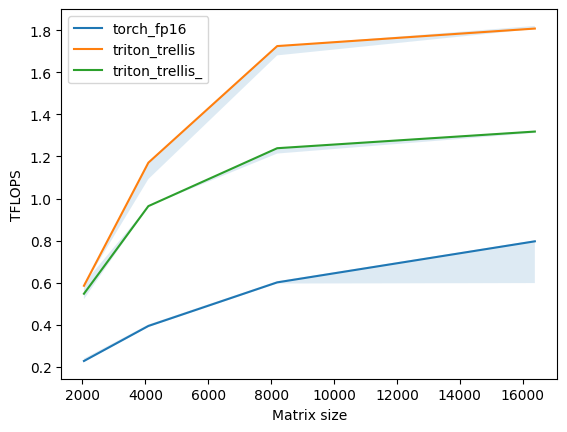

In [6]:
BS = 1
sizes = [2**11, 2**12, 2**13, 2**14]

BSs = [1, 16, 32, 128, 1024, 4096]
size = 4096

experiments = [
            "torch_fp16",
            "triton_trellis",
            "triton_trellis_",
            # "triton_trellis_old",
            ]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  # Argument names to use as an x-axis for the plot
        x_vals=[(size, BS, size) for size in sizes],
        # x_names=["M", "K", "N"],  # Argument names to use as an x-axis for the plot
        # x_vals=[(BS, size, size) for BS in BSs],
        # x_log=True,
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=experiments,
        line_names=experiments,
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
    x_fp16 = torch.randn(K, N, dtype=torch.float16, device="cuda")

    # y_fp8 = torch.randn((M, K), device="cuda").to(torch.float8_e5m2)
    # y_int8 = torch.randint(-128, 128, (M, K), dtype=torch.int8, device="cuda")

    x_compressed = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda")
    # x_compressed = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda").T.contiguous().T
    # x_compressed_old = torch.randint(0, 255, (K // 16, N * 4), dtype=torch.uint8, device="cuda")
    
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[MxKxN]: [{M}x{K}x{N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)

    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: test_trellis_triton(y_fp16, x_compressed), quantiles=quantiles)
        print("trellis_matmul_triton:", test_trellis_kernel.best_config)

    if provider == 'triton_trellis_':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: test_trellis_triton_(y_fp16, x_compressed), quantiles=quantiles)
        print("trellis_matmul_triton_:", test_trellis_kernel_.best_config)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)

In [7]:
# M, K, N = 1, 4096, 4096

# y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
# x_compressed = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda")

# o1 = test_trellis_triton(y_fp16, x_compressed)
# o2 = test_trellis_triton_(y_fp16, x_compressed)

# o1 - o2

In [8]:
# import triton.profiler as proton
# import triton.profiler.viewer as proton_viewer


# def show_profile(profile_name):
#     metric_names = ["time/ms"]
#     metric_names = ["tflop/s"] + metric_names
#     file_name = f"{profile_name}.hatchet"
#     tree, metrics = proton_viewer.parse(metric_names, file_name)
#     proton_viewer.print_tree(tree, metrics)


# def bench_kernel(M, K, N, reps=10):
#     print(f"Problem Shape = {M}x{K}x{N}")

#     y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
#     x_compressed = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda")

#     proton.activate(0)
#     for _ in range(reps):
#         _ = test_trellis_triton(y_fp16, x_compressed)
#     proton.deactivate(0)
#     print("Done benchmarking")


# BS = 16
# sizes = [2**11, 2**12, 2**13]

# proton.start("trellis_kernel", hook="triton")
# proton.deactivate(0)
# for s in sizes:
#     M, K, N = 16, s, s
#     bench_kernel(M, K, N, reps=1000)
# proton.finalize()
# show_profile("trellis_kernel")

In [9]:
# from torch.profiler import profile, record_function, ProfilerActivity


# M, K, N = 4096, 4096, 4096

# y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda")
# x_compressed = torch.randint(-2**31, 2**31, (K // 16, N), dtype=torch.int32, device="cuda")

# with profile(
#     activities=[ProfilerActivity.CUDA],
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# ) as prof:
#     with record_function("test_kernel"):
#         out = test_trellis_triton(y_fp16, x_compressed)


# print("Output shape:", out.shape)
# print("\n=== Profiler Results ===")
# print(prof.key_averages().table(sort_by="cuda_time_total"))